In [56]:
import numpy as np
import pandas as pd 
pd.set_option("max_columns",None)
from sklearn.linear_model import LinearRegression, Ridge
#from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.activations import relu,linear
#from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from matplotlib import units


import tensorflow as tf

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from datetime import datetime

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error,make_scorer,r2_score,mean_absolute_percentage_error
from sklearn.inspection import plot_partial_dependence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api  as sm
from scipy import stats
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import Lasso, Ridge, SGDRegressor,LinearRegression,RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,RobustScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor,DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
import pprint

pd.set_option('max_columns', 200)



In [3]:
#df = pd.ExcelFile('C:/Users/halil/Desktop/soalr_data.xlsx').parse('sheet 1')
weather_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="weather")
guneko_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="1000255-GUNEKO")

DATA INITILAZING AND CLEANING

In [4]:
guneko_production = guneko_raw[["Date","Production"]]
guneko_gti = guneko_raw[["Date.1","GTI"]]


weather_guneko = weather_raw.loc[weather_raw.name ==1000255]
ali = pd.merge(guneko_production,weather_guneko,left_on="Date",right_on="date")
dataset = ali.drop(["name","date","lat","lon"],axis=1)

ONE HOT ENCODING

In [5]:
dataset= dataset.set_index(["Date"])
year = pd.DataFrame(data=pd.get_dummies(dataset.index.year,prefix="year"))
month = pd.DataFrame(data=pd.get_dummies(dataset.index.month, prefix="month"))
#day = pd.DataFrame(data=pd.get_dummies(dataset.index.day,prefix="day"))
hour = pd.DataFrame(data=pd.get_dummies(dataset.index.hour,prefix="hour"))
#frames = [year,month,day,hour]
frames = [year,month,hour]
onehot_encoded = ali.join(frames)



FEATURE ENGINEERING

In [6]:
onehot_encoded = onehot_encoded.drop(["Date","name","date","lat","lon"],axis=1)

NORMALIZATION OF FEATURES (EXCEPTIONS: PRODUCTION AND DATE TIME ENCODED FEATURES)

In [7]:
def normalize(df,column_list):
    for col in column_list:
        feature_range = (-1,1)
        min_max_scaler = MinMaxScaler(feature_range=feature_range)

        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))

    return df

In [ ]:
normalized = normalize(onehot_encoded,onehot_encoded.columns[0:11])
normalized

In [39]:
target = normalized.loc[normalized.year_2021 == 1]
target = target.drop(["year_2020","year_2022","year_2021"],axis=1)
target = target.reset_index(drop=True)

In [ ]:
aw = normalized.loc[normalized.year_2022 == 1]
aw1 = aw.loc[aw.month_1 ==1]
aw1

In [ ]:
from keras.models import Sequential 
from tensorflow.keras import model_conf
from keras.layers import BatchNormalization, Dense, Add 
from keras.layers import Activation, Dropout, Flatten, Dense
def residual_block(x):
  x_skip = x
  x = Dense(model_conf['neuron_size'],activation='relu',kernel_regularizer=model_conf['regulizer'])(x)
  x = BatchNormalization()(x)
  x = Dropout(model_conf['dropout'])(x)

  x = Dense(model_conf['neuron_size'],activation='relu',kernel_regularizer=model_conf['regulizer'])(x)
  x = BatchNormalization()(x)
  x = Dropout(model_conf['dropout'])(x)

  adding = Add()([x_skip,x])
  return Activation('relu')(adding)

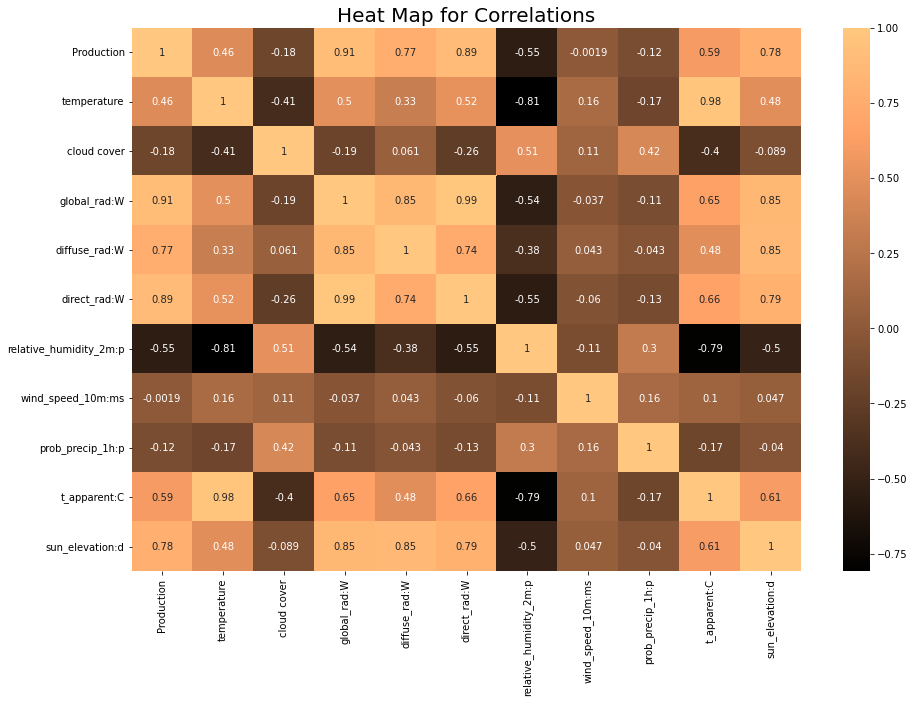

In [45]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(onehot_encoded.iloc[:,:11].corr(), cmap = 'copper',annot = True)
plt.title('Heat Map for Correlations', fontsize = 20)
plt.show()

In [10]:
train = target[:7692]
test = target[7692:]

In [11]:
x_train = train.copy()
x_test = test.copy()

y_train = x_train.pop('Production')
y_test = x_test.pop('Production')

In [11]:
y  = normalized["Production"]
x = normalized.drop("Production",axis=1)
#train test split

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,shuffle=False,random_state=1)

In [23]:
%%time
clfs = []
seed = 3

clfs.append(("LinearRegression", Pipeline([("LogReg", LinearRegression())])))

clfs.append(("XGB", Pipeline([("XGB", XGBRegressor())]))) 

clfs.append(("KNN", Pipeline([("KNN", KNeighborsRegressor())]))) 

clfs.append(("DTR", Pipeline([("DecisionTrees", DecisionTreeRegressor())]))) 

clfs.append(("RFRegressor", Pipeline([("RandomForest", RandomForestRegressor())]))) 

clfs.append(("GBRegressor", Pipeline([("GradientBoosting", GradientBoostingRegressor())]))) 

clfs.append(("MLP", Pipeline([("MLP Regressor", MLPRegressor())])))

clfs.append(("EXT Regressor",Pipeline([("ExtraTrees", ExtraTreeRegressor())])))

clfs.append(("SV Regressor", Pipeline([("ExtraTrees", SVR())])))

scoring = 'r2'
n_folds = 10
msgs = []
results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=None)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())
    msgs.append(msg)
    print(msg)

LinearRegression: -31948708741916053733376.000000 (+/- 95846126225748152811520.000000)
XGB: 0.890477 (+/- 0.074957)
KNN: 0.886669 (+/- 0.072553)
DTR: 0.823922 (+/- 0.096256)
RFRegressor: 0.904314 (+/- 0.062686)
GBRegressor: 0.894121 (+/- 0.066000)
MLP: 0.895516 (+/- 0.071611)
EXT Regressor: 0.822167 (+/- 0.116703)
SV Regressor: 0.905660 (+/- 0.058297)
Wall time: 38.2 s


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,make_scorer,r2_score,mean_absolute_percentage_error,explained_variance_score

def metrics(y_train1,y_train_pred1,y_test1,y_test_pred1):
    print("for train data, mean squared error is",mean_squared_error(y_train1, y_train_pred1))
    print("for train data, mean absolute error is:",mean_absolute_error(y_train1, y_train_pred1))
    print("for train data, mean absolute percentage error is",mean_absolute_percentage_error(y_train1, y_train_pred1),"\n")

    print("for test data, mean squared error is",mean_squared_error(y_test1, y_test_pred1))
    print("for test data, mean absolute error is:",mean_absolute_error(y_test1, y_test_pred1))
    print("for test data, mean absolute percentage error is",mean_absolute_percentage_error(y_test1, y_test_pred1))


In [62]:
def build_and_compile_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  return model

In [63]:
ali = build_and_compile_model()
ali.fit(x_train,y_train,batch_size=64,epochs=50)

Epoch 1/50
121/121 [==============================] - 0s 1ms/step - loss: 0.1777 - mean_absolute_error: 0.1777
Epoch 2/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0771 - mean_absolute_error: 0.0771
Epoch 3/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0694 - mean_absolute_error: 0.0694
Epoch 4/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0660 - mean_absolute_error: 0.0660
Epoch 5/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0645 - mean_absolute_error: 0.0645
Epoch 6/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0625 - mean_absolute_error: 0.0625
Epoch 7/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0608 - mean_absolute_error: 0.0608
Epoch 8/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0608 - mean_absolute_error: 0.0608
Epoch 9/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0598 - mean_absolute_error: 0.0598
E

In [57]:

my_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16,activation="relu"),
    tf.keras.layers.Dense(units=1,activation="linear")
])

my_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
    loss='mse')

my_model.fit(x_train,y_train,batch_size=64,epochs=50)

Epoch 1/50
121/121 [==============================] - 0s 1ms/step - loss: 0.1155 - mean_absolute_error: 0.2158
Epoch 2/50
121/121 [==============================] - 0s 2ms/step - loss: 0.0294 - mean_absolute_error: 0.0950
Epoch 3/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0270 - mean_absolute_error: 0.0849
Epoch 4/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0263 - mean_absolute_error: 0.0836
Epoch 5/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0253 - mean_absolute_error: 0.0784
Epoch 6/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0248 - mean_absolute_error: 0.0768
Epoch 7/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0243 - mean_absolute_error: 0.0752
Epoch 8/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0239 - mean_absolute_error: 0.0729
Epoch 9/50
121/121 [==============================] - 0s 1ms/step - loss: 0.0238 - mean_absolute_error: 0.0741
E

In [45]:
reg = LinearRegression()
reg.fit(x_train, y_train)

reg_train_pred = reg.predict(x_train)
reg_test_pred = reg.predict(x_test)

metrics(y_train,reg_train_pred,y_test,reg_test_pred)


for train data, mean squared error is 0.032896146769059276
for train data, mean absolute error is: 0.10639368345018735
for train data, mean absolute percentage error is 0.5263428246964387 

for test data, mean squared error is 5.6040153175515235e+22
for test data, mean absolute error is: 236728015189.40512
for test data, mean absolute percentage error is 838758352296.179


In [42]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

xgb_train_pred = xgb.predict(x_train)
xgb_test_pred = xgb.predict(x_test)

metrics(y_train,xgb_train_pred,y_test,xgb_test_pred)



for train data, mean squared error is 0.001585586188426985
for train data, mean absolute error is: 0.019847477151901972
for train data, mean absolute percentage error is 0.1543493285237681 

for test data, mean squared error is 0.03807303537587897
for test data, mean absolute error is: 0.08720837932325866
for test data, mean absolute percentage error is 0.585500759511294


In [43]:

KN = KNeighborsRegressor()
KN.fit(x_train, y_train)

KN_train_pred = KN.predict(x_train)
KN_test_pred = KN.predict(x_test)

metrics(y_train,KN_train_pred,y_test,KN_test_pred)


for train data, mean squared error is 0.02026280612948404
for train data, mean absolute error is: 0.055029027987946344
for train data, mean absolute percentage error is 0.40131186599042795 

for test data, mean squared error is 0.03330210121583113
for test data, mean absolute error is: 0.08678253012958088
for test data, mean absolute percentage error is 0.5076838732134478


In [44]:
DTree = DecisionTreeRegressor()
DTree.fit(x_train, y_train)

DTree_train_pred = DTree.predict(x_train)
DTree_test_pred = DTree.predict(x_test)

metrics(y_train,DTree_train_pred,y_test,DTree_test_pred)


for train data, mean squared error is 1.922925373491156e-35
for train data, mean absolute error is: 1.7320171991032084e-19
for train data, mean absolute percentage error is 1.7577437878881462e-19 

for test data, mean squared error is 0.060449590445979154
for test data, mean absolute error is: 0.10141005202733597
for test data, mean absolute percentage error is 0.8049861997650862


In [46]:
r_forest = RandomForestRegressor()
r_forest.fit(x_train, y_train)

r_forest_train_pred = r_forest.predict(x_train)
r_forest_test_pred = r_forest.predict(x_test)

metrics(y_train,r_forest_train_pred,y_test,r_forest_test_pred)


for train data, mean squared error is 0.003327371994828791
for train data, mean absolute error is: 0.022365633964697932
for train data, mean absolute percentage error is 0.1439649184065176 

for test data, mean squared error is 0.04169489152464611
for test data, mean absolute error is: 0.0883167117735019
for test data, mean absolute percentage error is 0.7048346614234545


####################################################################################